# Liquid Time-Constant (LTC) prototype
Custom LTC cell (no external LTC library) with 2-D context `[fp_fb_gap, energy_ratio]` used to modulate the time constant.


In [12]:
import math
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, f1_score

# Optional install for torchdiffeq
try:
    from torchdiffeq import odeint
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torchdiffeq'])
    from torchdiffeq import odeint

# Config
ROI_START, ROI_END = 700, 840  # widen ROI
CONTEXT_FEATURES = ['fp_fb_gap', 'energy_ratio', 'bounce_available']
BATCH_SIZE = 64
HIDDEN_SIZE = 20
EPOCHS = 15
LR = 5e-4
TEST_SIZE = 0.2
VAL_SIZE = 0.25  # of trainval
KFOLDS = 5
GRAD_CLIP_NORM = 1.0
LOSS_CLS_W = 5.0
LOSS_REG_W = 0.0  # drop regression for classification focus
BOUNCE_LOSS_W = 1.0
LTC_UNFOLD_STEPS = 6  # fewer inner steps for speed

# Paths
ROOT = Path('..')
DATA_PATH = ROOT / 'dataset' / 'uwb_preprocessed.csv'



## Load and prepare data
- Keep only rows with both context features present.
- Extract ROI waveform as sequence input.
- Build LOS/NLOS labels and an optional bounce flag for demonstration.


In [13]:
df = pd.read_csv(DATA_PATH)

# Bounce availability flag
df['bounce_available'] = df['fp_fb_gap'].notna().astype(np.float32)

# Bounce target (1 if bounce gap present)
y_bounce = df['bounce_available'].to_numpy(dtype=np.float32)

# Fill missing gap with 0
df['fp_fb_gap'] = df['fp_fb_gap'].fillna(0.0)
# Fill missing energy_ratio with 0
df['energy_ratio'] = df['energy_ratio'].fillna(0.0)

print('Rows after fill:', len(df))

# ROI waveform
roi_cols = [f'CIR{i}' for i in range(ROI_START, ROI_END + 1)]
X_roi = df[roi_cols].to_numpy(dtype=np.float32)

# Context vector
X_ctx = df[['fp_fb_gap', 'energy_ratio', 'bounce_available']].to_numpy(dtype=np.float32)

# Labels
y_nlos = (df['Label'] == 'NLOS').astype(np.float32).to_numpy()

# Distance target
y_dist = df['d_true'].to_numpy(dtype=np.float32)

# Train/val/test split
data = (X_roi, X_ctx, y_nlos, y_dist, y_bounce)
X_roi_trainval, X_roi_test, X_ctx_trainval, X_ctx_test, y_nlos_trainval, y_nlos_test, y_dist_trainval, y_dist_test, y_bounce_trainval, y_bounce_test = train_test_split(
    *data, test_size=TEST_SIZE, stratify=y_nlos, random_state=42
)

X_roi_train, X_roi_val, X_ctx_train, X_ctx_val, y_nlos_train, y_nlos_val, y_dist_train, y_dist_val, y_bounce_train, y_bounce_val = train_test_split(
    X_roi_trainval, X_ctx_trainval, y_nlos_trainval, y_dist_trainval, y_bounce_trainval,
    test_size=VAL_SIZE, stratify=y_nlos_trainval, random_state=42
)

# Standardize ROI and context using train stats
roi_mean = X_roi_train.mean(axis=0, keepdims=True)
roi_std = X_roi_train.std(axis=0, keepdims=True) + 1e-6
ctx_mean = X_ctx_train.mean(axis=0, keepdims=True)
ctx_std = X_ctx_train.std(axis=0, keepdims=True) + 1e-6

X_roi_train = (X_roi_train - roi_mean) / roi_std
X_roi_val = (X_roi_val - roi_mean) / roi_std
X_roi_test = (X_roi_test - roi_mean) / roi_std

X_ctx_train = (X_ctx_train - ctx_mean) / ctx_std
X_ctx_val = (X_ctx_val - ctx_mean) / ctx_std
X_ctx_test = (X_ctx_test - ctx_mean) / ctx_std

# pos_weight for BCE (NLOS=1)
pos_count = y_nlos_train.sum()
neg_count = len(y_nlos_train) - pos_count
POS_WEIGHT = float(neg_count / (pos_count + 1e-6))
print('Class counts train: pos', pos_count, 'neg', neg_count, 'pos_weight', POS_WEIGHT)

print('Train:', len(X_roi_train), 'Val:', len(X_roi_val), 'Test:', len(X_roi_test))



Rows after fill: 8000
Class counts train: pos 2400.0 neg 2400.0 pos_weight 1.0
Train: 4800 Val: 1600 Test: 1600


## Dataset and DataLoader

In [14]:
class UWBDataset(Dataset):
    def __init__(self, roi, ctx, y_nlos, y_bounce):
        self.roi = torch.from_numpy(roi)  # [N, T]
        self.ctx = torch.from_numpy(ctx)  # [N, 3]
        self.y_nlos = torch.from_numpy(y_nlos)
        self.y_bounce = torch.from_numpy(y_bounce)
    def __len__(self):
        return len(self.roi)
    def __getitem__(self, idx):
        x_seq = self.roi[idx].unsqueeze(-1)  # [T,1]
        ctx = self.ctx[idx]
        return x_seq, ctx, self.y_nlos[idx], self.y_bounce[idx]

train_ds = UWBDataset(X_roi_train, X_ctx_train, y_nlos_train, y_bounce_train)
val_ds = UWBDataset(X_roi_val, X_ctx_val, y_nlos_val, y_bounce_val)
test_ds = UWBDataset(X_roi_test, X_ctx_test, y_nlos_test, y_bounce_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


## Context-LTC cell (manual)
Implements a simple continuous-time update: `dh/dt = (-h + W_x x + W_h h + b) / tau`, discretized with step `dt=1`.
Tau is modulated by the 2-D context via `tau = tau_base * (1 + sigmoid(W_ctx C + b_ctx))`.


In [15]:
class OptimizedContextLTC(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, context_size: int = 2,
                 tau_min: float = 0.1, tau_max: float = 10.0, unfold_steps: int = 10):
        super().__init__()
        self.hidden_size = hidden_size
        self.unfold_steps = unfold_steps
        self.tau_min = tau_min
        self.tau_max = tau_max

        self.W_x = nn.Linear(input_size, hidden_size)
        self.W_h = nn.Linear(hidden_size, hidden_size)
        self.act = nn.Tanh()
        self.W_ctx = nn.Linear(context_size, hidden_size)
        self.h0 = nn.Linear(context_size, hidden_size)

    def get_tau(self, ctx):
        gate = torch.sigmoid(self.W_ctx(ctx))
        return self.tau_min + (self.tau_max - self.tau_min) * gate

    def forward(self, x_seq, ctx):
        B, T, _ = x_seq.shape
        device = x_seq.device

        # context-aware initial hidden state
        h = self.act(self.h0(ctx))
        curr_tau = self.get_tau(ctx)
        x_seq_mapped = self.W_x(x_seq)

        # Stability Fix: dt must be <= tau_min
        dt = 1.0 / self.unfold_steps

        outputs = []
        for t in range(T):
            x_in = x_seq_mapped[:, t, :]
            for _ in range(self.unfold_steps):
                numerator = self.act(x_in + self.W_h(h))
                alpha = dt / curr_tau
                h = (h + alpha * numerator) / (1 + alpha)

            outputs.append(h)

        h_seq = torch.stack(outputs, dim=1)
        return h_seq, h

class UWBModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, context_size=3):
        super().__init__()
        # Use the optimized cell
        self.ltc = OptimizedContextLTC(
            input_size=input_size,
            hidden_size=hidden_size,
            context_size=context_size,
            tau_min=0.1,  # Fast reaction
            tau_max=10.0,  # Long memory
            unfold_steps=LTC_UNFOLD_STEPS,
        )
        self.dropout = nn.Dropout(0.1)
        self.head_nlos = nn.Linear(hidden_size + context_size, 1)
        self.head_bounce = nn.Linear(hidden_size + context_size, 1)
        self.head_reg = nn.Linear(hidden_size + context_size, 1)

    def forward(self, x_seq, ctx):
        _, h_last = self.ltc(x_seq, ctx)
        z = torch.cat([h_last, ctx], dim=-1)
        z = self.dropout(z)
        nlos_logit = self.head_nlos(z).squeeze(-1)
        bounce_logit = self.head_bounce(z).squeeze(-1)
        dist_pred = self.head_reg(z).squeeze(-1)
        return nlos_logit, bounce_logit, dist_pred




## Training loop (demo)
Trains briefly on LOS/NLOS and bounce heads; regression head predicts distance. Uses class-balanced losses.


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UWBModel(input_size=1, hidden_size=HIDDEN_SIZE, context_size=3).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable params (LTC):', total_params)

pos_weight_t = torch.tensor([POS_WEIGHT], dtype=torch.float32, device=device)
bce_nlos = nn.BCEWithLogitsLoss(pos_weight=pos_weight_t)
bce_bounce = nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(model.parameters(), lr=LR)

history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

def eval_split(loader):
    model.eval()
    nlos_probs = []
    nlos_true = []
    total_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for x_seq, ctx, y_nlos_b, y_bounce_b in loader:
            x_seq = x_seq.to(device)
            ctx = ctx.to(device)
            y_nlos_b = y_nlos_b.to(device)
            y_bounce_b = y_bounce_b.to(device)
            nlos_logit, bounce_logit, _ = model(x_seq, ctx)
            loss = LOSS_CLS_W * bce_nlos(nlos_logit, y_nlos_b) + BOUNCE_LOSS_W * bce_bounce(bounce_logit, y_bounce_b)
            total_loss += loss.item() * len(x_seq)
            n_samples += len(x_seq)
            prob = torch.sigmoid(nlos_logit)
            nlos_probs.append(prob.cpu())
            nlos_true.append(y_nlos_b.cpu())
    nlos_probs = torch.cat(nlos_probs)
    nlos_true = torch.cat(nlos_true)
    thresholds = torch.linspace(0.1, 0.9, steps=17)
    best_acc = 0.0
    best_f1 = 0.0
    best_th = 0.5
    for th in thresholds:
        preds = (nlos_probs > th).float()
        acc = accuracy_score(nlos_true, preds)
        f1 = f1_score(nlos_true, preds)
        if acc > best_acc:
            best_acc = acc; best_th = th.item()
        if f1 > best_f1:
            best_f1 = f1; best_th_f1 = th.item()
    try:
        auc = roc_auc_score(nlos_true, nlos_probs)
    except ValueError:
        auc = float('nan')
    val_loss = total_loss / n_samples
    return val_loss, best_acc, best_f1, auc, best_th

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for x_seq, ctx, y_nlos_b, y_bounce_b in train_loader:
        x_seq = x_seq.to(device)
        ctx = ctx.to(device)
        y_nlos_b = y_nlos_b.to(device)
        y_bounce_b = y_bounce_b.to(device)

        nlos_logit, bounce_logit, _ = model(x_seq, ctx)
        loss = LOSS_CLS_W * bce_nlos(nlos_logit, y_nlos_b) + BOUNCE_LOSS_W * bce_bounce(bounce_logit, y_bounce_b)

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
        opt.step()
        total_loss += loss.item() * len(x_seq)
    avg_loss = total_loss / len(train_ds)

    val_loss, val_acc, val_f1, val_auc, best_th = eval_split(val_loader)
    history['train_loss'].append(avg_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)

    print(f"Epoch {epoch}: train_loss={avg_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.3f} val_f1={val_f1:.3f} val_auc={val_auc:.3f} best_th={best_th:.2f}")

# Final test metrics (reuse best threshold from last val eval)
test_loss, test_acc, test_f1, test_auc, _ = eval_split(test_loader)
print(f"Test: acc={test_acc:.3f} f1={test_f1:.3f} auc={test_auc:.3f}")




Trainable params (LTC): 692
Epoch 1: train_loss=3.6878 val_loss=3.4782 val_acc=0.743 val_f1=0.784 val_auc=0.901 best_th=0.50
Epoch 2: train_loss=3.3296 val_loss=3.1500 val_acc=0.774 val_f1=0.794 val_auc=0.884 best_th=0.60
Epoch 3: train_loss=2.9832 val_loss=2.7369 val_acc=0.769 val_f1=0.805 val_auc=0.868 best_th=0.50
Epoch 4: train_loss=2.6813 val_loss=2.5706 val_acc=0.774 val_f1=0.810 val_auc=0.881 best_th=0.50
Epoch 5: train_loss=2.5800 val_loss=2.4680 val_acc=0.781 val_f1=0.816 val_auc=0.888 best_th=0.50
Epoch 6: train_loss=2.4701 val_loss=2.3769 val_acc=0.802 val_f1=0.813 val_auc=0.913 best_th=0.65
Epoch 7: train_loss=2.3509 val_loss=2.2172 val_acc=0.814 val_f1=0.825 val_auc=0.924 best_th=0.65
Epoch 8: train_loss=2.2175 val_loss=2.1042 val_acc=0.860 val_f1=0.858 val_auc=0.941 best_th=0.65
Epoch 9: train_loss=2.1002 val_loss=1.9752 val_acc=0.881 val_f1=0.877 val_auc=0.953 best_th=0.65
Epoch 10: train_loss=2.0030 val_loss=1.8478 val_acc=0.903 val_f1=0.903 val_auc=0.969 best_th=0.65
E

## Training curves

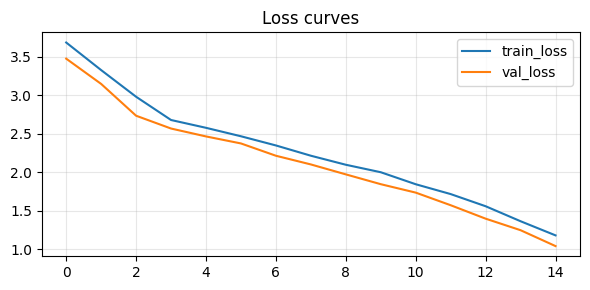

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('Loss curves')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Notes
- Context vector = `[fp_fb_gap, energy_ratio]` feeds the tau modulation: `tau = tau_base * (1 + sigmoid(W_ctx C + b_ctx))`.
- Heads: LOS/NLOS (binary), bounce heuristic (binary), distance regression.
- Adjust `GAP_MIN/GAP_MAX` or drop the bounce loss if you don?t want the heuristic head.
- Expand ROI or add normalization as needed for your final pipeline.


## Baseline models: LSTM / CNN / Transformer

In [18]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def _get_constant(name, default):
    if name in globals():
        return globals()[name]
    print(f"Warning: {name} not defined; using default {default}")
    return default

def train_eval_model(model, epochs=5, lr=5e-4, pos_weight=None, loss_cls_w=None, grad_clip_norm=None):
    pos_weight = _get_constant('POS_WEIGHT', 1.0) if pos_weight is None else pos_weight
    loss_cls_w = _get_constant('LOSS_CLS_W', 1.0) if loss_cls_w is None else loss_cls_w
    grad_clip_norm = _get_constant('GRAD_CLIP_NORM', 1.0) if grad_clip_norm is None else grad_clip_norm

    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    pos_w_tensor = torch.tensor([pos_weight], device=device, dtype=torch.float32)
    bce_local = nn.BCEWithLogitsLoss(pos_weight=pos_w_tensor)

    history = []
    best_th = 0.5

    for epoch in range(1, epochs + 1):
        # --- TRAINING ---
        model.train()
        tot = 0.0
        for x_seq, ctx, y, y_bounce in train_loader:
            x_seq, ctx, y = x_seq.to(device), ctx.to(device), y.to(device)
            logit = model(x_seq, ctx)
            loss = loss_cls_w * bce_local(logit, y)

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)
            opt.step()

            tot += loss.item() * len(x_seq)

        train_loss = tot / len(train_ds)

        # --- VALIDATION ---
        model.eval()
        probs = []
        ys = []
        vtot = 0.0
        ns = 0

        with torch.no_grad():
            for x_seq, ctx, y, y_bounce in val_loader:
                x_seq, ctx, y = x_seq.to(device), ctx.to(device), y.to(device)
                logit = model(x_seq, ctx)
                loss = loss_cls_w * bce_local(logit, y)
                vtot += loss.item() * len(x_seq)
                ns += len(x_seq)

                p = torch.sigmoid(logit)
                probs.append(p.cpu())
                ys.append(y.cpu())

        val_loss = vtot / ns
        probs = torch.cat(probs)
        ys = torch.cat(ys)

        thresholds = torch.linspace(0.1, 0.9, steps=17)
        best_acc = 0.0
        best_f1 = 0.0
        epoch_best_th = 0.5

        for th in thresholds:
            preds = (probs > th).float()
            acc = accuracy_score(ys, preds)
            f1 = f1_score(ys, preds)
            if acc > best_acc:
                best_acc = acc
                epoch_best_th = th.item()
            if f1 > best_f1:
                best_f1 = f1

        best_th = epoch_best_th

        try:
            auc = roc_auc_score(ys, probs)
        except ValueError:
            auc = float('nan')

        history.append((epoch, train_loss, val_loss, best_acc, best_f1, auc, best_th))
        print(f"Epoch {epoch}: train_loss={train_loss:.3f} val_loss={val_loss:.3f} "
              f"val_acc={best_acc:.3f} val_f1={best_f1:.3f} val_auc={auc:.3f} best_th={best_th:.2f}")

    # --- TESTING ---
    model.eval()
    probs = []
    ys = []
    with torch.no_grad():
        for x_seq, ctx, y, y_bounce in test_loader:
            x_seq, ctx, y = x_seq.to(device), ctx.to(device), y.to(device)
            logit = model(x_seq, ctx)
            p = torch.sigmoid(logit)
            probs.append(p.cpu())
            ys.append(y.cpu())

    probs = torch.cat(probs)
    ys = torch.cat(ys)
    preds = (probs > best_th).float()

    test_acc = accuracy_score(ys, preds)
    test_f1 = f1_score(ys, preds)
    try:
        test_auc = roc_auc_score(ys, probs)
    except ValueError:
        test_auc = float('nan')

    print(f"Test: acc={test_acc:.3f} f1={test_f1:.3f} auc={test_auc:.3f}")

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('Trainable params:', total_params)

    return history



In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, context_dim=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size + context_dim, 1)

    def forward(self, x_seq, ctx):
        # x_seq: [B, T, 1]
        # ctx:   [B, context_dim]
        _, (h_last, _) = self.lstm(x_seq)
        h_last = h_last.squeeze(0)
        z = torch.cat([h_last, ctx], dim=-1)
        return self.fc(z).squeeze(-1)

class CNN1DModel(nn.Module):
    def __init__(self, input_channels=1, context_dim=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(32 + context_dim, 1)

    def forward(self, x_seq, ctx):
        # x_seq: [B, T, 1] -> Transpose to [B, 1, T] for Conv1d
        x = x_seq.transpose(1, 2)
        feat = self.conv(x).squeeze(-1)  # [B, 32]
        z = torch.cat([feat, ctx], dim=-1)
        return self.fc(z).squeeze(-1)

class TransformerModel(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_layers=2, context_dim=3):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=64, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model + context_dim, 1)

    def forward(self, x_seq, ctx):
        x = self.input_proj(x_seq)  # [B, T, d_model]
        h = self.encoder(x)
        h_last = h[:, -1, :]        # Take the last token output
        z = torch.cat([h_last, ctx], dim=-1)
        return self.fc(z).squeeze(-1)

### LSTM baseline


In [20]:
print('--- LSTM Baseline ---')
lstm_history = train_eval_model(LSTMModel(input_size=1, hidden_size=64, context_dim=3), epochs=EPOCHS)



--- LSTM Baseline ---
Epoch 1: train_loss=3.228 val_loss=2.879 val_acc=0.749 val_f1=0.790 val_auc=0.729 best_th=0.20
Epoch 2: train_loss=2.811 val_loss=2.769 val_acc=0.726 val_f1=0.781 val_auc=0.807 best_th=0.65
Epoch 3: train_loss=2.662 val_loss=2.693 val_acc=0.775 val_f1=0.795 val_auc=0.874 best_th=0.65
Epoch 4: train_loss=2.574 val_loss=2.630 val_acc=0.767 val_f1=0.796 val_auc=0.820 best_th=0.55
Epoch 5: train_loss=2.205 val_loss=2.303 val_acc=0.792 val_f1=0.807 val_auc=0.876 best_th=0.45
Epoch 6: train_loss=2.029 val_loss=1.901 val_acc=0.842 val_f1=0.843 val_auc=0.929 best_th=0.55
Epoch 7: train_loss=1.662 val_loss=1.567 val_acc=0.893 val_f1=0.892 val_auc=0.954 best_th=0.65
Epoch 8: train_loss=1.402 val_loss=1.245 val_acc=0.936 val_f1=0.935 val_auc=0.977 best_th=0.65
Epoch 9: train_loss=0.930 val_loss=0.979 val_acc=0.948 val_f1=0.948 val_auc=0.977 best_th=0.45
Epoch 10: train_loss=0.633 val_loss=0.501 val_acc=0.981 val_f1=0.981 val_auc=0.997 best_th=0.65
Epoch 11: train_loss=0.459 

### CNN baseline


In [21]:
print('--- CNN Baseline ---')
cnn_history = train_eval_model(CNN1DModel(input_channels=1, context_dim=3), epochs=EPOCHS)



--- CNN Baseline ---
Epoch 1: train_loss=3.003 val_loss=2.856 val_acc=0.755 val_f1=0.798 val_auc=0.767 best_th=0.45
Epoch 2: train_loss=2.775 val_loss=2.712 val_acc=0.758 val_f1=0.801 val_auc=0.778 best_th=0.45
Epoch 3: train_loss=2.628 val_loss=2.568 val_acc=0.764 val_f1=0.804 val_auc=0.824 best_th=0.45
Epoch 4: train_loss=2.461 val_loss=2.404 val_acc=0.823 val_f1=0.830 val_auc=0.920 best_th=0.55
Epoch 5: train_loss=2.267 val_loss=2.220 val_acc=0.901 val_f1=0.903 val_auc=0.965 best_th=0.55
Epoch 6: train_loss=2.053 val_loss=2.039 val_acc=0.944 val_f1=0.942 val_auc=0.987 best_th=0.60
Epoch 7: train_loss=1.837 val_loss=1.845 val_acc=0.955 val_f1=0.954 val_auc=0.990 best_th=0.55
Epoch 8: train_loss=1.621 val_loss=1.688 val_acc=0.953 val_f1=0.952 val_auc=0.991 best_th=0.55
Epoch 9: train_loss=1.442 val_loss=1.565 val_acc=0.954 val_f1=0.953 val_auc=0.991 best_th=0.55
Epoch 10: train_loss=1.286 val_loss=1.466 val_acc=0.956 val_f1=0.955 val_auc=0.992 best_th=0.60
Epoch 11: train_loss=1.167 v

### Transformer baseline


In [22]:
print('--- Transformer Baseline ---')
transformer_history = train_eval_model(TransformerModel(d_model=32, nhead=4, num_layers=2, context_dim=3), epochs=EPOCHS)



--- Transformer Baseline ---
Epoch 1: train_loss=2.879 val_loss=2.580 val_acc=0.736 val_f1=0.778 val_auc=0.819 best_th=0.50
Epoch 2: train_loss=2.596 val_loss=2.459 val_acc=0.752 val_f1=0.795 val_auc=0.835 best_th=0.45
Epoch 3: train_loss=2.485 val_loss=2.391 val_acc=0.764 val_f1=0.799 val_auc=0.846 best_th=0.45
Epoch 4: train_loss=2.388 val_loss=2.144 val_acc=0.796 val_f1=0.808 val_auc=0.886 best_th=0.55
Epoch 5: train_loss=1.965 val_loss=1.558 val_acc=0.863 val_f1=0.872 val_auc=0.949 best_th=0.65
Epoch 6: train_loss=1.410 val_loss=1.242 val_acc=0.916 val_f1=0.921 val_auc=0.970 best_th=0.20
Epoch 7: train_loss=1.091 val_loss=0.953 val_acc=0.932 val_f1=0.933 val_auc=0.976 best_th=0.55
Epoch 8: train_loss=1.041 val_loss=0.949 val_acc=0.932 val_f1=0.935 val_auc=0.980 best_th=0.55
Epoch 9: train_loss=0.967 val_loss=0.989 val_acc=0.935 val_f1=0.935 val_auc=0.979 best_th=0.80
Epoch 10: train_loss=0.955 val_loss=0.887 val_acc=0.933 val_f1=0.934 val_auc=0.980 best_th=0.45
Epoch 11: train_loss